## Vehicle Detection Project 
### by Abanoub David Awad  

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

---

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


We'll start off our notebook by importing our packages.


In [22]:
import os
import cv2
import glob
import copy
import time
import pickle
import numpy as np
from math import floor
from math import fabs
from os.path import join
from os.path import isfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from collections import deque
from scipy.ndimage.measurements import label
from IPython.display import HTML
from moviepy.editor import VideoFileClip

%matplotlib inline

print("modules loaded")

modules loaded


## Reading in our training data 

In [3]:
def read_training_data():
    vehicle_images = glob.glob('./data/vehicles/*/*.png')
    non_vehicle_images = glob.glob('./data/non-vehicles/*/*.png')
    return (vehicle_images, non_vehicle_images)

cars, notcars = read_training_data()

print("Done loading training filenames")
print("Number of car images: ", len(cars))
print("Number of non-car images: ", len(notcars))

Done loading training filenames
Number of car images:  8792
Number of non-car images:  8968


## Let's take a quick look at some of our vehicle images to see what we're looking at with our dataset. 

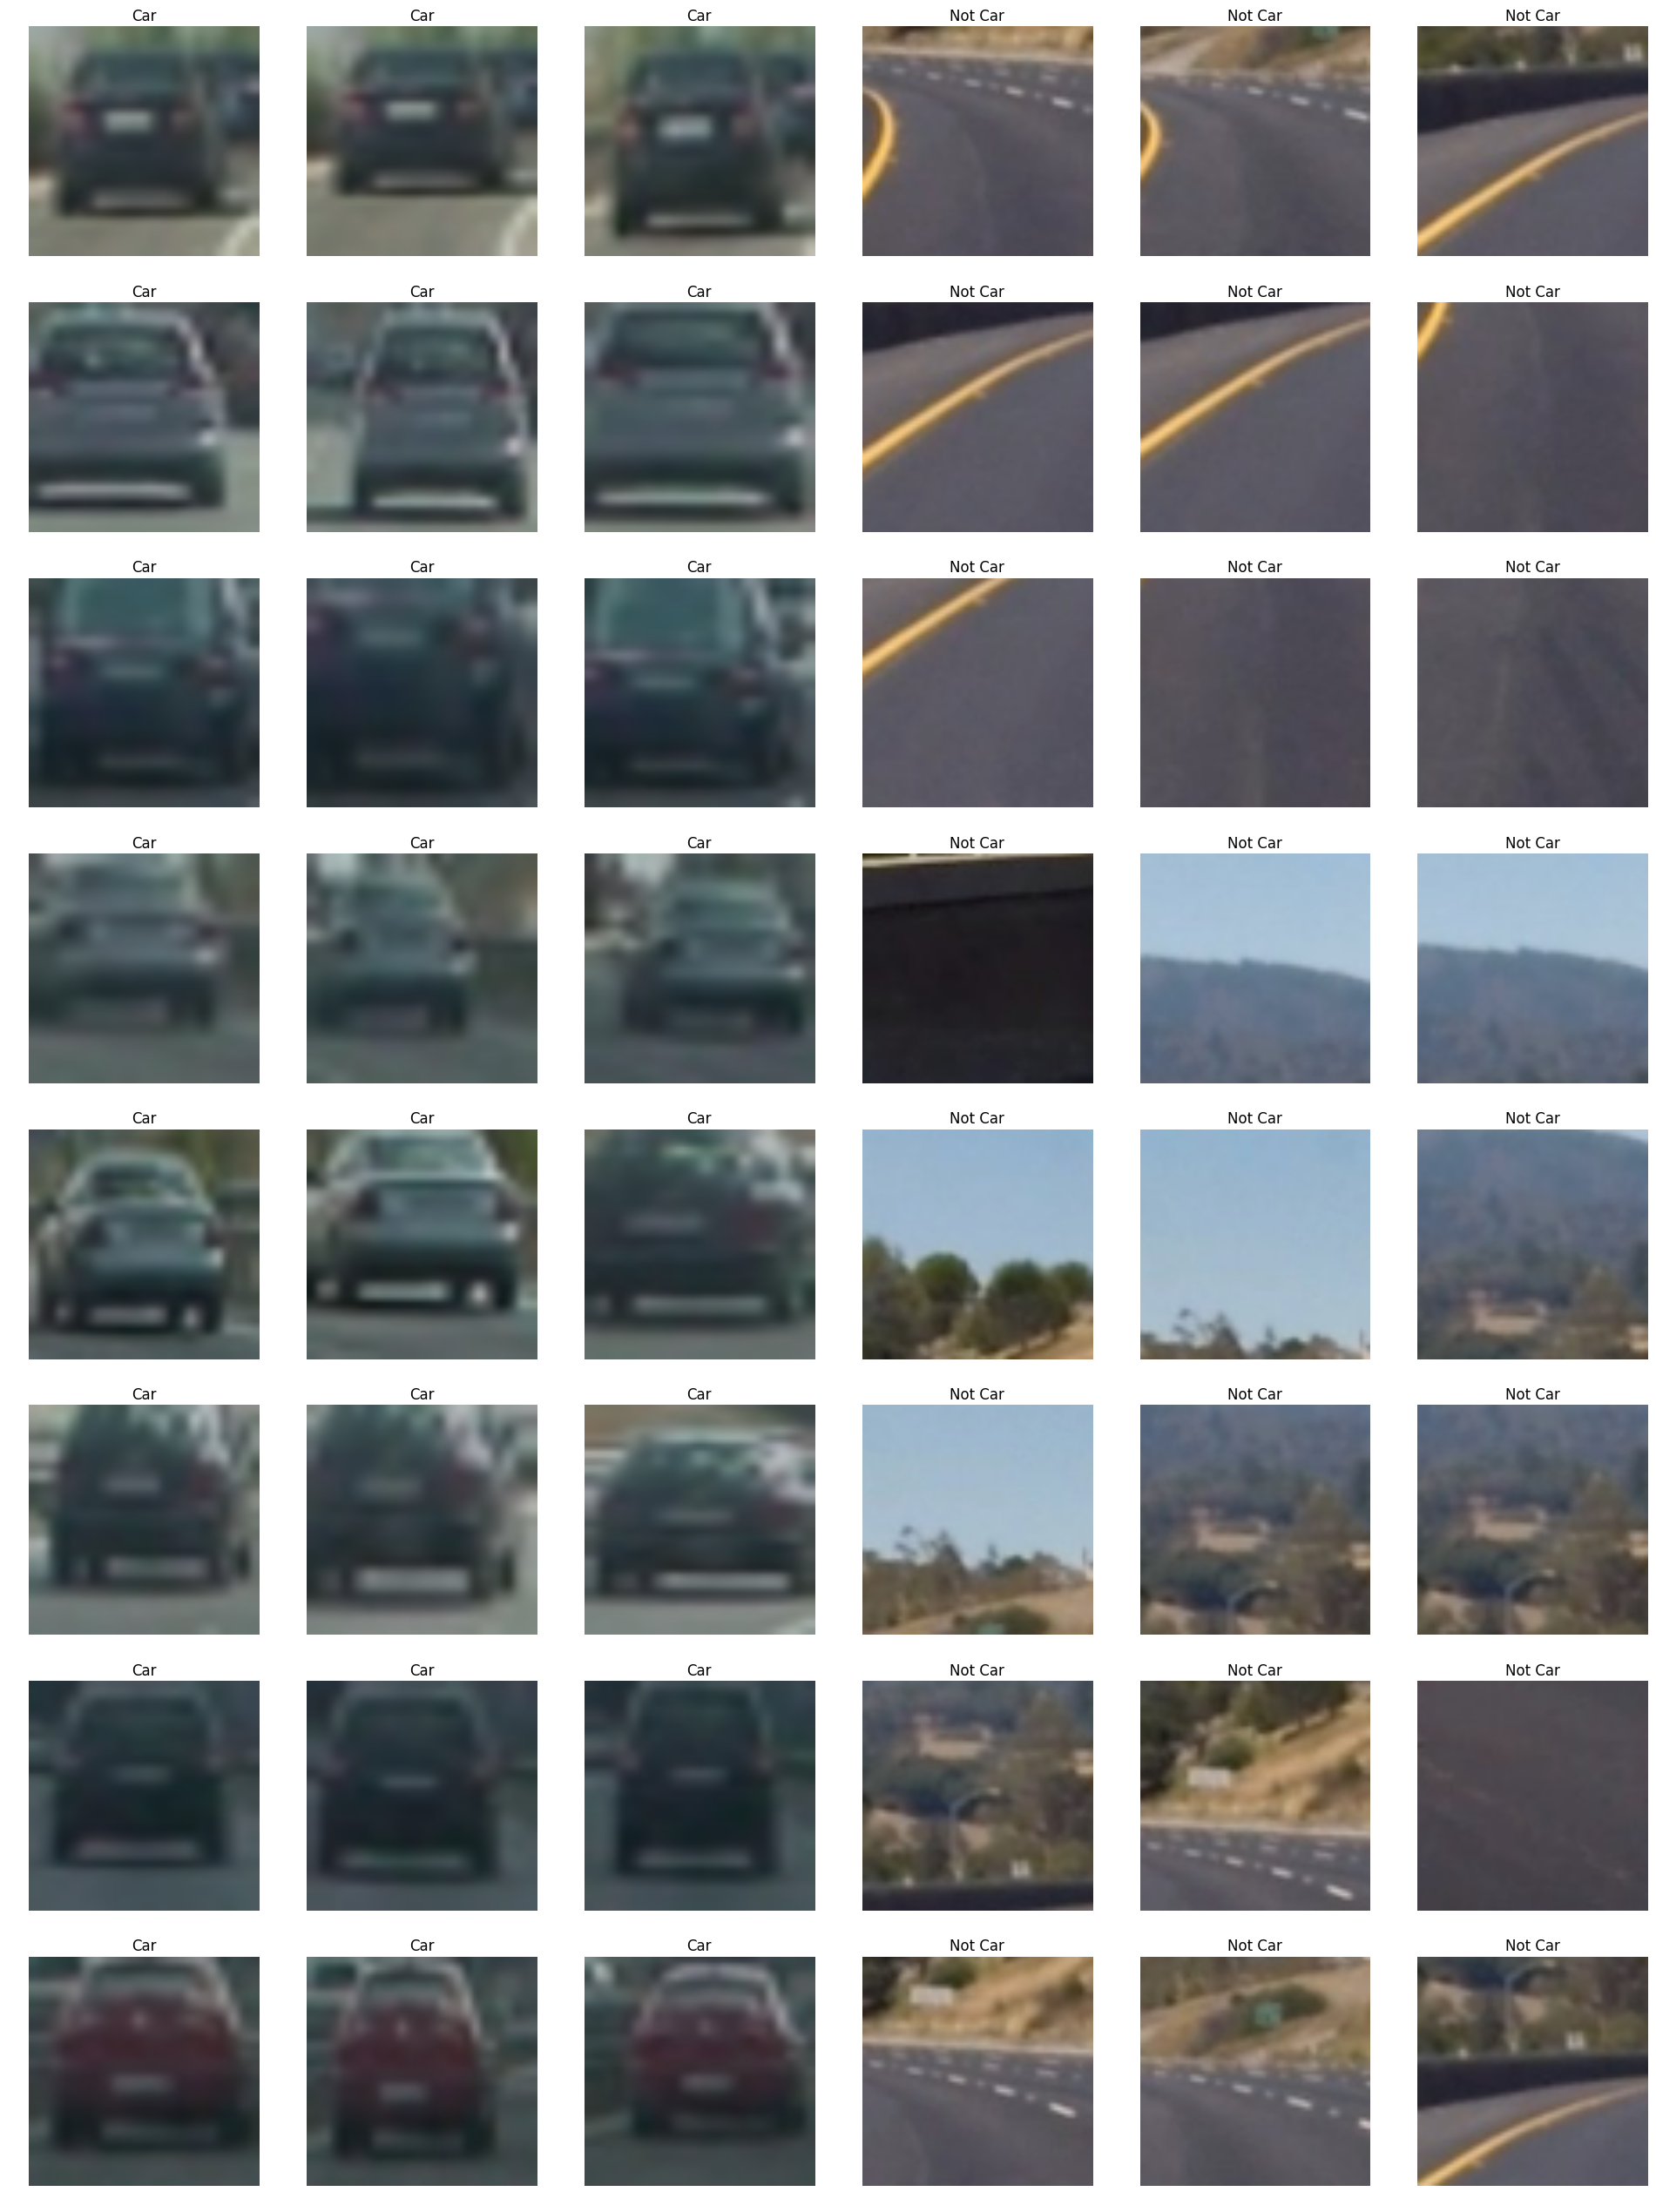

In [4]:
plt_rows = 8
plt_cols = 6
plt.subplots(plt_rows, plt_cols, figsize=(plt_cols*4, plt_rows*4))
for i in range(0, plt_rows * plt_cols):
    plt.subplot(plt_rows, plt_cols, i+1)
    if i % plt_cols < plt_cols/2:
        plt.title('Car')
        plt.axis('off')
        plt.imshow(mpimg.imread(cars[i]))
    else:
        plt.title('Not Car')
        plt.axis('off')
        plt.imshow(mpimg.imread(notcars[i]))

## Building convenienience methods to make this process feasible. 

We start by defining `get_hog_features` based on the lesson to get us HOG features and a useful visualization if need be. 


We then define `bin_color_features` to create a feature vector of out image. 

`color_hist` concatenates color features together in order for us to get an idea of color concentration.

Concatenated feature vectors are created in order of spatial features, color histogram features, and then HOG features.

In [28]:
# utility functions 
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)   


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# bin color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# color histogram features 
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    hist_a = np.histogram(img[:,:,0], bins=nbins)
    hist_b = np.histogram(img[:,:,1], bins=nbins)
    hist_c = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((hist_a[0], hist_b[0], hist_c[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        file_features = extract_img_features(image, color_space, spatial_size,
                            hist_bins, orient, 
                            pix_per_cell, cell_per_block, hog_channel,
                            spatial_feat, hist_feat, hog_feat)
        features.append(file_features.tolist())
    return features


# Define a function to extract features from a single image window
# just for a single image rather than list of images
def extract_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    # Define an empty list to receive features
    img_features = []
    
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
        
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
        
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)

        # Append features to list
        img_features.append(hist_features)
    
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)

        # Append features to list
        img_features.append(hog_features)

    # Return concatenated array of features
    return np.concatenate(img_features)



# takes an image and the list of windows to be searched
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    
    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterate over all windows in the list
    for window in windows:
        
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # Extract features for that window using single_img_features()
        features = extract_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # classifier prediction
        prediction = clf.predict(test_features)
        
        # save the window
        if prediction == 1:
            on_windows.append(window)

    return on_windows

    
# take an image, start and stop positions in both x and y, 
# window size (x and y dimensions),
# and overlap fraction (for both x and y)

# Try y_start_stop of 400, 656

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(150, 64), xy_overlap=(0.8, 0.8)):

    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes


def apply_threshold(heatmap, threshold):
    cp_heatmap = copy.deepcopy(heatmap)
    # Zero out pixels below the threshold
    cp_heatmap[cp_heatmap <= threshold] = 0
    # Return thresholded map
    return cp_heatmap


def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def detect_vehicles(img):
    draw_image = np.copy(img)
    image = img.astype(np.float32)/255 # color fix for image weirdness

    # y_start_stop = [450, 600]
    
    y_start_stop = [395, 650] 
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 96), xy_overlap=(0.5, 0.5))

    y_start_stop = [395, 650] 
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))

    y_start_stop = [395, 550]
    windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(48, 48), xy_overlap=(0.45, 0.45))
    
    windows = windows2 + windows3 + windows4
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img, hot_windows, windows2, windows3, windows4


def detect_vehicles(img):
    draw_image = np.copy(img)
    image = img.astype(np.float32)/255

    # y_start_stop = [450, 600]
    
    y_start_stop = [395, 650] # Min and max in y to search in slide_window()
    windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(128, 96), xy_overlap=(0.5, 0.5))

    y_start_stop = [395, 650] # Min and max in y to search in slide_window()
    windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.8, 0.8))

    y_start_stop = [395, 550] # Min and max in y to search in slide_window()
    windows4 = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(48, 48), xy_overlap=(0.45, 0.45))
    windows = windows2 + windows3 + windows4

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    return window_img, hot_windows, windows2, windows3, windows4


print('functions loaded!')

functions loaded!


## Setting up our data, hyperparameters, and our features

Some justification should be given for the parameters used below. 


After watching the livestream, I decided to simply use all three features, the spacial, histogram, and HOG and combining them into a normalized feature vector as we're shown in the lesson. 

I had tried using only HOG features and found that that didn't work nearly as well for classification. 

The livestream recommends we start with YCrCb for our color space, and throughout this unit we've found that different color spaces are useful for different purposes and this was especially true here, I tried RGB and HSV and found huge hits to classification accuracy.


Continuing with experimentation I tried using a smaller spatial sizes but it seems like once we go below 32x32 we can't reliably derive features as we've lost too much information despite it being faster. 


In [24]:
# hyperparameters

color_space  = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb


spatial_feat = True     # Use Spatial features
spatial_size = (32, 32) # Spatial binning dimensions


hist_feat = True        # Use Histogram features
hist_bins = 32          # Number of histogram bins

hog_feat = True         # Use HOG features
orient = 9              # HOG orientations
pix_per_cell = 8        # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
hog_channel = 'ALL'     # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

400.78 Seconds to extract features...


## Creating our classifier



In [26]:
# Create our SVM classifier of cars

# Create our randomized training and test sets
rand_state = np.random.randint(0, 8765309)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


print('Training SVM Classifier: ')

print('Orientations:          %s' % orient)
print('Pixels per cell:       %s' % pix_per_cell)
print('Cells per Block:       %s' % cell_per_block) 
print('Feature vector length: %s' % str(len(X_train[0])))


svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()

print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Training SVM Classifier: 
Orientations:          9
Pixels per cell:       8
Cells per Block:       2
Feature vector length: 8460
95.65 Seconds to train SVC...
Test Accuracy of SVC =  0.9904


## Searching for cars in our test images

We'll start testing by searching our test images for vehicles using our extracted features and searching windows in the image and applying extracted features from those images to our SVM classifier. 

processing ./test_images/test1.jpg
5.98 seconds to process ./test_images/test1.jpg
processing ./test_images/test2.jpg
7.33 seconds to process ./test_images/test2.jpg
processing ./test_images/test3.jpg
6.07 seconds to process ./test_images/test3.jpg
processing ./test_images/test4.jpg
7.19 seconds to process ./test_images/test4.jpg
processing ./test_images/test5.jpg
6.38 seconds to process ./test_images/test5.jpg
processing ./test_images/test6.jpg
5.91 seconds to process ./test_images/test6.jpg


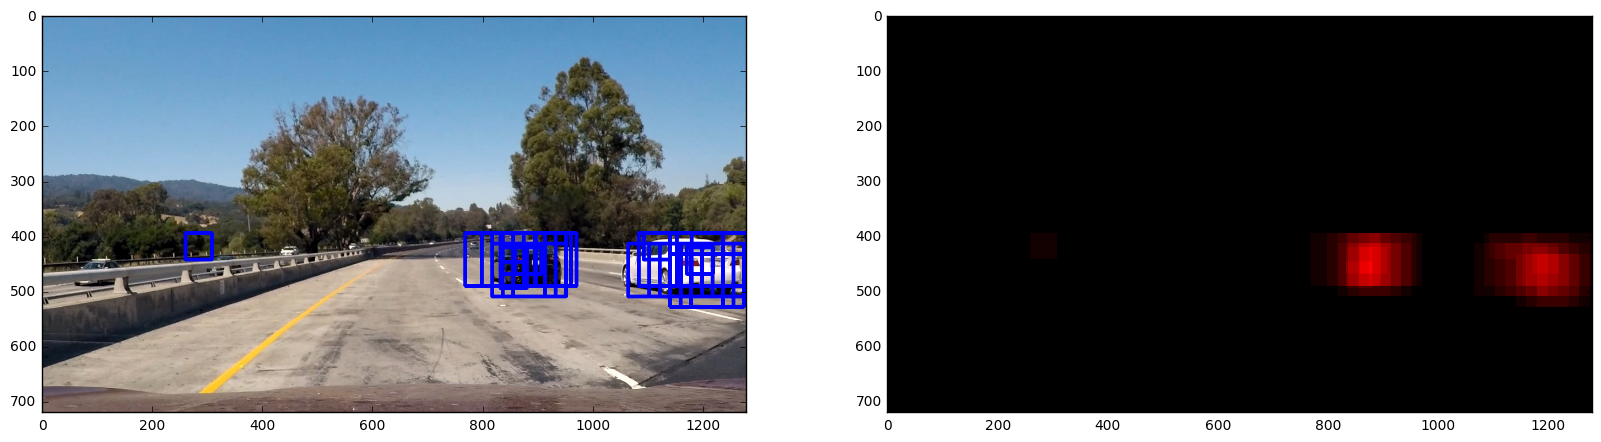

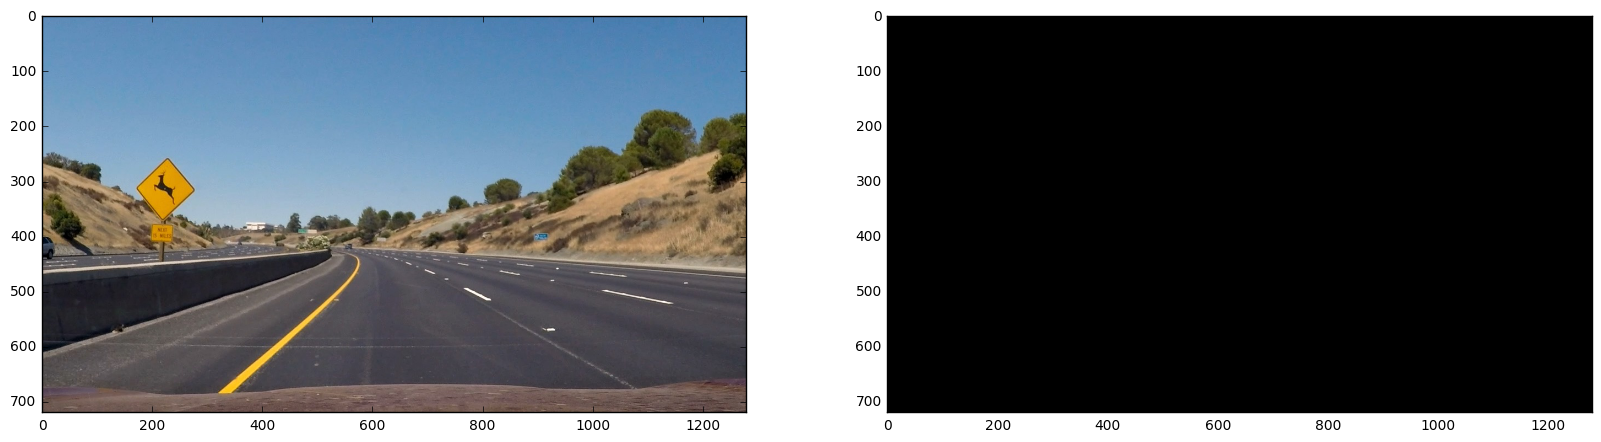

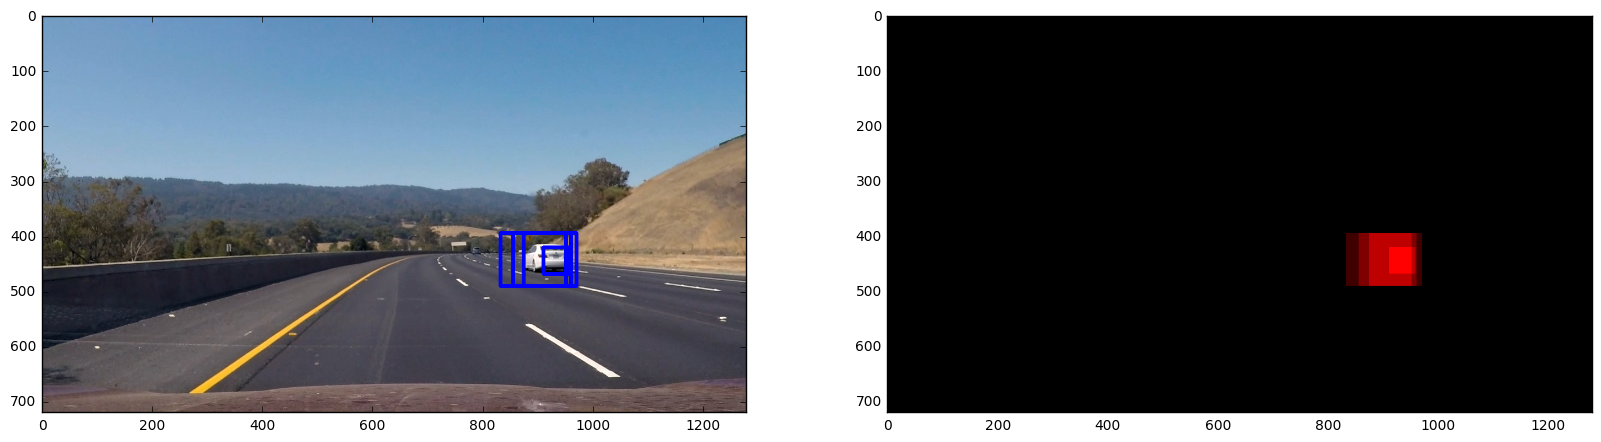

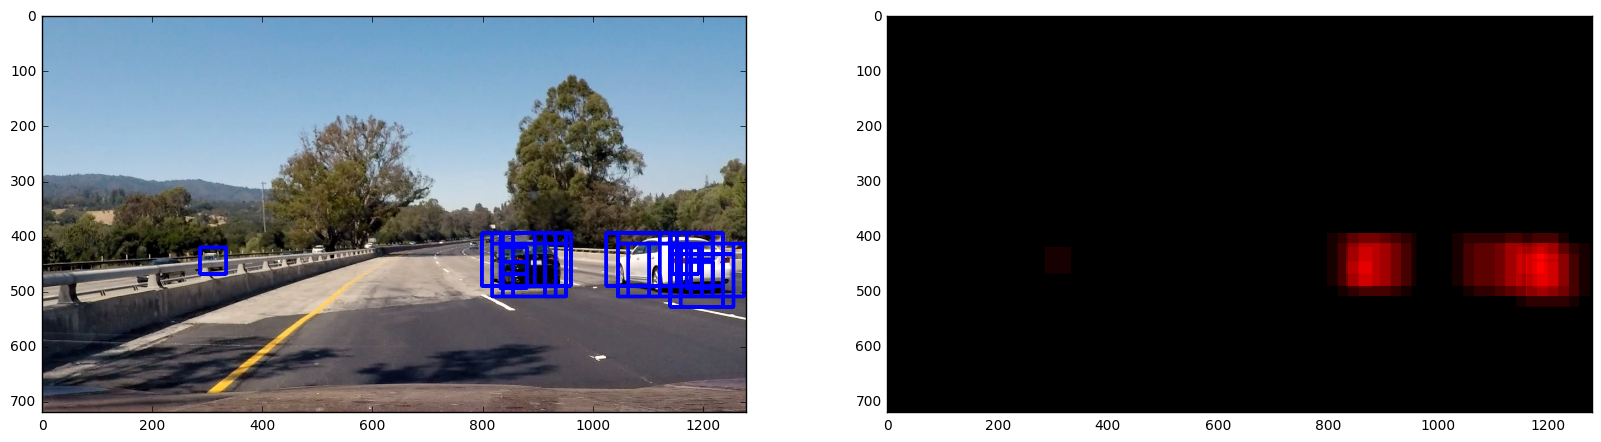

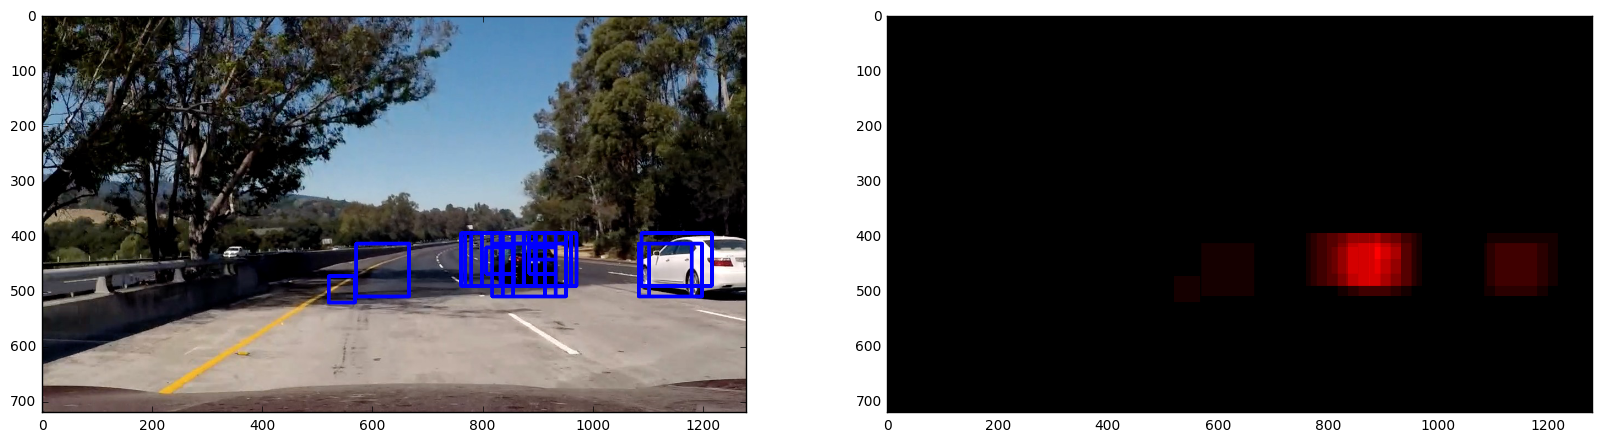

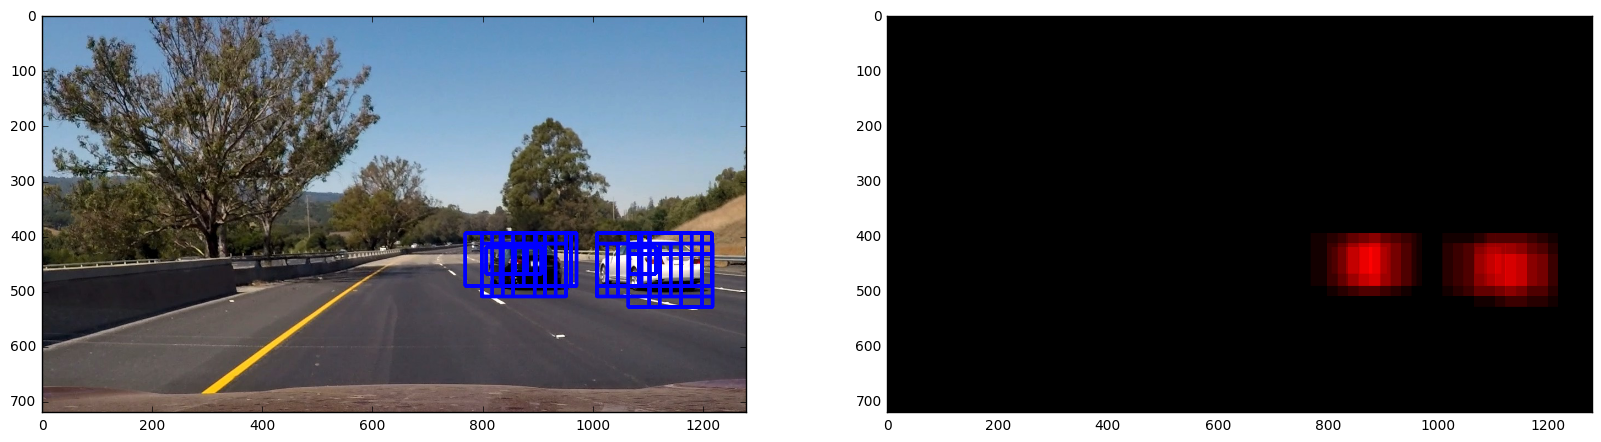

In [29]:
# apply our search and classification to the test images

test_images = glob.glob('./test_images/*.jpg')

# index of test images
i = 1

# iterate through all of our test images and apply our heat maps
for sample in test_images:
    print("processing %s" % sample)
    t1 = time.time()
    
    img = mpimg.imread(sample)
    
    last_bboxes = []
    window_img, bboxes, windows2, windows3, windows4 = detect_vehicles(img)
    last_bboxes.append(bboxes)
    last_bboxes = last_bboxes[-16:]

    # Read in image similar to one shown above 
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    
    # Add heat to each box in box list
    full_heat = add_heat(heat, [bbox for bboxes in last_bboxes for bbox in bboxes])
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(full_heat, 5)
    
    # Visualize the heatmap when displaying    
    full_heatmap = np.clip(full_heat, 0, 255)
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    norm = plt.Normalize(vmin=full_heatmap.min(), vmax=full_heatmap.max())
    norm_heatmap = norm(full_heatmap)
    heatmap_image = (np.dstack((norm_heatmap*255, norm_heatmap, norm_heatmap))).astype(np.uint8)

    # plot our results 
    ax1.imshow(window_img)
    ax2.imshow(heatmap_image)

    # cv2 is dumb and needs BGR images
    vahicles_marked = cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR)

    f_name = './output_images/test' + str(i) + '.jpg'
    # save our images
    cv2.imwrite(f_name, vahicles_marked)
    t2 = time.time()
    
    i += 1 
    print(round(t2 - t1, 2), 'seconds to process %s' % sample)

    

### success! 

It looks like we've actually done pretty well for creating our heatmaps and detecting vehicles!

Although you can see in our last example that we actually have a false positive in that _unusually car shaped tree_ over there. For the most part though we do properly identify the cars in the photo much better than we do that tree, and then can go on to use the number of overlapping boxes as an indicator of what's a car and what isn't. 

In [11]:
def final_pipeline(image):
    global last_bboxes
    global show_hot_windows
    window_img, bboxes, windows2, windows3, windows4 = detect_vehicles(image)

    last_bboxes.append(bboxes)
    last_bboxes = last_bboxes[-16:]
    
    # Read in similar image
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # add heat to the windows
    full_heat = add_heat(heat, [bbox for bboxes in last_bboxes for bbox in bboxes])

    # remove false positives with heat threshold
    heat = apply_threshold(full_heat, 15)

    # show our heatmap    
    full_heatmap = np.clip(full_heat, 0, 255)
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    if (show_hot_windows):
        norm = plt.Normalize(vmin=full_heatmap.min(), vmax=full_heatmap.max())
        norm_heatmap = norm(full_heatmap)
        heatmap_image = (np.dstack((norm_heatmap*255, norm_heatmap, norm_heatmap))).astype(np.uint8)
        draw_img = cv2.addWeighted(heatmap_image, 1, draw_img, 1, 0)
    
    return draw_img


print('loaded the final pipeline function~ ')

loaded the final pipeline function~ 


### small debugging video

In the below cell we'll run our pipeline on a [2 second video] (./test_video) to make sure our algorithm is functioning the way we expect. This is to save time and catch any small errors before running it on our larger 50 second project video as I'm writing this project on a 2013 macbook air with 4GB of RAM and no graphics card.

In [21]:
last_bboxes = []
show_hot_windows = False
t=time.time()

# read in the project video
input_video_filename = 'test_video.mp4'
output_video_filename = 'test_output.mp4'

clip = VideoFileClip(input_video_filename)

# final_pipeline function 
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)


[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [04:05<00:06,  6.18s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 



In [19]:
# project video

last_bboxes = []
show_hot_windows = False
t=time.time()

# read in the project video
input_video_filename = 'project_video.mp4'
output_video_filename = 'project_output.mp4'

clip = VideoFileClip(input_video_filename)

# final_pipeline function 
clip = clip.fl_image(final_pipeline)
clip.write_videofile(output_video_filename, audio=False)

%time clip.write_videofile(output_video_filename, audio=False)


[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [2:21:05<00:06,  6.93s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [2:21:14<00:06,  6.58s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 2h 4min 36s, sys: 4min 8s, total: 2h 8min 45s
Wall time: 2h 21min 16s


In [20]:
output_video_filename = 'project_output.mp4'

HTML("""<h1> The project video </h1>
        <br>
        <video width="960" height="540" controls>
          <source src="{0}">
        </video>""".format(output_video_filename))


## Discussion 



### Potential improvements

Most of these potential improvements are things I was unable to do because of time constraints, but would be very interested in doing.


To quote the rubric, _"A stand out submission for this project will be a pipeline that runs in near real time (at least several frames per second on a good laptop) and does a great job of identifying and tracking vehicles in the frame with a minimum of false positives."_


This certainly is not the case on my 2013 Macbook air, which isn't a fantastic computer, but certainly hasn't had huge trouble running udacity assignments in the past. Certain portions or this project had taken as long as 2 hours to process the project video. 


I also would have loved to integrate the optional challenge of combining this with the advanced lane finding project in order to have a truly robust computer vision pipeline, and will certainly be doing that in the near future! 


In addition to the above, we could have a better classifier if we used Udacity's Annotated Driving Dataset as it has much more training data.


### Potential Causes of failure

We make a large assumption in the fact that we use mostly the bottom half of the video to search for our cars. This can become a problem when roads change or we're going uphill. 


## Thank you

Obviously a large portion of the progress we've made here comes from the learning resources as well as the [livestream](https://www.youtube.com/watch?v=P2zwrTM8ueA&index=5&list=PLAwxTw4SYaPkz3HerxrHlu1Seq8ZA7-5P) that were very informative and helpful. 

This was a fantastic project and I had a great time working on it. Thank you to the udacity instructors and mentors.


These example images come from a combination of the GTI vehicle image database, the KITTI vision benchmark suite, and the Udacity self driving car education team. 
